# M02. Predict PAs
- Predict outs vs. safe
- Predict out type
- Predict safe type

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

db_path = r'C:\Users\james\Documents\MLB\Database\MLBDB.db'
engine = create_engine(f'sqlite:///{db_path}')

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import joblib
import matplotlib.pyplot as plt

In [3]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

In [4]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

In [209]:
complete_dataset = create_pa_inputs(2023, 2023, short=50, long=300)

In [217]:
complete_dataset[['eventsModel', 'event']].query('eventsModel == "lo"').value_counts()

eventsModel  event       
lo           Lineout         10306
             Bunt Lineout        7
dtype: int64

In [6]:
#### Move
# Assuming complete_merged_df is your DataFrame
complete_dataset['startingPitcher'] = complete_dataset.groupby(['gamePk', 'halfInning'])['pitcherName'].transform('first')
complete_dataset['starter'] = (complete_dataset['startingPitcher'] == complete_dataset['pitcherName']).astype('int')

##### Inputs

In [7]:
# Batters
with open(os.path.join(model_path, "batter_stats_scaler_20231027.pkl"), "rb") as file:
    batter_stats_scaler = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_stats_scaler_20231027.pkl"), "rb") as file:
    pitcher_stats_scaler = pickle.load(file)

In [8]:
# Standardize
complete_dataset[batter_inputs] = batter_stats_scaler.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = pitcher_stats_scaler.transform(complete_dataset[pitcher_inputs])

### Steamer

In [9]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [10]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [11]:
# Batters
with open(os.path.join(model_path, "batter_stats_fg_scaler_20231027.pkl"), "rb") as file:
    batter_stats_fg_scaler = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_stats_fg_scaler_20231027.pkl"), "rb") as file:
    pitcher_stats_fg_scaler = pickle.load(file)

In [12]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = pitcher_stats_fg_scaler.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

In [13]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [14]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 

# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')

### Impute

##### Option 1: Steamer

In [15]:
# Batters
with open(os.path.join(model_path, "batter_imputations_model_20231027.pkl"), "rb") as file:
    batter_imputations_model = pickle.load(file)
# Pitchers
with open(os.path.join(model_path, "pitcher_imputations_model_20231027.pkl"), "rb") as file:
    pitcher_imputations_model = pickle.load(file)

In [16]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

4218/4218 [==============================] - 2s 491us/step


##### Option 2: 0s

In [17]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

In [18]:
# complete_dataset[pa_inputs].agg(['min', 'mean', 'max'])

In [19]:
# complete_merged_df[pa_inputs].agg(['min', 'mean', 'max'])

### Train Models

##### Dataset

In [20]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"').reset_index(drop=True)
# Drop early observations (these will generally treat veterans as rookies and could bias results
complete_merged_df = complete_merged_df.drop(index=complete_merged_df.index[:20000])
complete_merged_df.reset_index(inplace=True, drop=True)
# Create year variable
complete_merged_df['year'] = complete_merged_df['date'].astype('str').str[:4]
# Create is_out binary variable
out_list = ['so', 'fo', 'go', 'lo', 'po']
complete_merged_df['is_out'] = complete_merged_df['eventsModel'].str.contains('|'.join(out_list)).astype(int)

In [21]:
pa_inputs = pa_inputs + ['starter']

In [22]:
# Keep relevant variables
keep_list = pa_inputs + ['pa_b', 'pa_p', 'year', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
model_dataset = complete_merged_df[keep_list]

In [23]:
outs_dataset = model_dataset[model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset = model_dataset[~model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

### Train/Test Split

##### Option 1: Early/Late Season

In [24]:
# X_train = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
# X_test = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

##### Option 2: Random

In [25]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Drop if missing information
model_dataset.dropna(subset=pa_inputs, inplace=True)
model_dataset.columns = model_dataset.columns.astype(str)

# Split the DataFrame into training and testing sets based on the 'split' column
X_train = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
X_test = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)

In [26]:
outs_dataset_train = X_train[X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_train = X_train[~X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [27]:
outs_dataset_test = X_test[X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset_test = X_test[~X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [28]:
del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2  

In [29]:
X_train.head(1)

,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,p_L,b_L,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_16,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2535,venue_2536,venue_2602,venue_2680,venue_2681,venue_2701,venue_2735,venue_2756,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5010,venue_5325,venue_5365,venue_5381,venue_5445,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,x_vect,y_vect,temperature,onFirst,onSecond,onThird,inning,top,outs_pre,score_diff,imp_b,imp_p,starter,pa_b,pa_p,year,is_out,eventsModel,batterName,pitcherName
1,0.569023,-0.646542,1.327907,0.285564,-0.032168,0.498160,-1.037041,-0.620690,0.247439,-0.424965,2.294843,-1.952965,-0.591550,-1.365629,-1.321818,-2.098832,-1.104233,0.360053,0.510483,0.527498,0.548106,-0.237684,-0.547831,0.684182,-0.869001,1.740796,0.366237,-0.032382,0.646934,-1.167658,-0.756827,0.275223,-0.564444,2.934376,-2.384311,-0.675665,-1.697580,-1.549768,-2.516907,-1.397993,0.451928,0.633417,0.620594,0.661881,-0.558275,-0.690168,-0.005927,-0.078434,1.286423,-0.316109,-0.452982,-0.541520,-1.574124,-0.578106,0.941634,3.494831,-0.153453,-0.140866,0.234101,-0.610335,1.244589,-0.554679,-0.606191,-0.043175,-0.059708,-0.354414,-0.236467,-0.581948,-1.185420,-0.225467,0.004843,1.024772,-0.027102,-0.889574,0.205204,-2.160374,0.482764,1.170803,3.148496,-0.092275,-1.164460,-0.495470,-1.548763,0.301184,-1.326134,-0.926357,0.154991,0.018859,-0.542038,-0.274058,-0.655268,-1.401471,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-3.535534,3.535534,70,1,1,0,7,1,2,-3.000000,0,0,1,50.000000,50.000000,2015,0,bb,Freddy Galvis,Doug Fister


### Outs vs. Safe

In [47]:
%%time
layers = (30,30,30)

binary_filename = "model_binary_" + "voting_" + f"{todaysdate}.sav"
print(binary_filename)


# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, max_iter=10),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, max_iter=10),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=4, max_iter=10),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1, learning_rate_init=0.0001, max_iter=10),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, learning_rate_init=0.0001, max_iter=10),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, learning_rate_init=0.0001, max_iter=10),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=4, learning_rate_init=0.0001, max_iter=10),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=5, learning_rate_init=0.0001, max_iter=10),
    ]


# Create the ensemble classifier using VotingClassifier
model_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train[pa_inputs], X_train[['is_out']].values.ravel())

# Save model
pickle.dump(model_binary, open(os.path.join(model_path, binary_filename), 'wb'))

model_binary_voting_20240128.sav
CPU times: total: 703 ms
Wall time: 1min 38s


In [48]:
# Make predictions
proba = model_binary.predict_proba(X_test[pa_inputs])
X_test['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_out_pred']  = proba[:, 1]  # Assign the second column of probabilities

In [49]:
### Add xtiles (to examine how well predictions match actual results)
# model_dataset['decile'] = pd.qcut(model_dataset['is_out_pred'], 10, labels=False)

# df_name = "is_out" + "_df"
# globals()[df_name] = model_dataset.groupby('decile').mean().reset_index()

X_test['decile'] = pd.qcut(X_test['is_out_pred'], 10, labels=False)

df_name = "is_out" + "_df"
globals()[df_name] = X_test.groupby('decile').mean().reset_index()

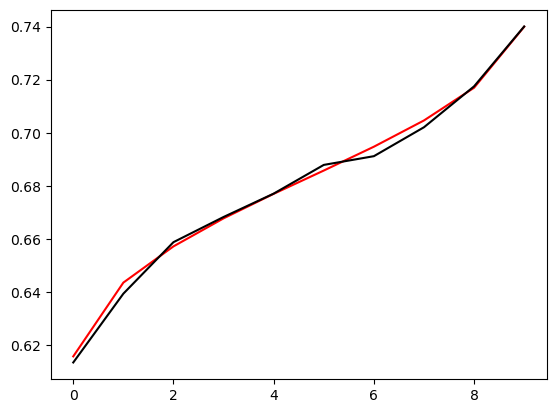

In [50]:
# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

In [51]:
X_test.query('year == "2022" | year == "2023"')[['is_out_pred', 'is_out']].mean()

is_out_pred   0.687707
is_out        0.684263
dtype: float64

In [52]:
X_test.groupby('decile')[['is_out_pred', 'is_out']].mean()

,is_out_pred,is_out
decile,,
0,0.615776,0.613481
1,0.643563,0.639398
2,0.657203,0.658792
3,0.667754,0.668273
4,0.676988,0.677072
5,0.685757,0.687884
6,0.694735,0.691168
7,0.704624,0.702065
8,0.716943,0.717467


In [36]:
# 10 iters, (30,30,30,30,30), 9 pieces
# decile
# 0   0.612016
# 1   0.642671
# 2   0.655747
# 3   0.665716
# 4   0.674411
# 5   0.682552
# 6   0.690928
# 7   0.700736
# 8   0.713929
# 9   0.739453
# Name: is_out_pred, dtype: float64

### Outs

In [37]:
%%time
# Neural network layers
layers = (30,30,30)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 20

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=4, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=5, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=6, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=7, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_dataset_train[pa_inputs], outs_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

model_outs_relu_303030_20_20240128.sav
CPU times: total: 672 ms
Wall time: 2min 37s


In [38]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_dataset_test[pa_inputs])
for i, col in enumerate(outs_outputs_pred):
    outs_dataset_test[f'{col}'] = proba[:, i]

In [39]:
# Create deciles
for var in outs_outputs:
    outs_dataset_test[f'{var}_act'] = (outs_dataset_test['eventsModel'] == var).astype('int')
    outs_dataset_test['decile'] = pd.qcut(outs_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = outs_dataset_test.groupby('decile').mean().reset_index()

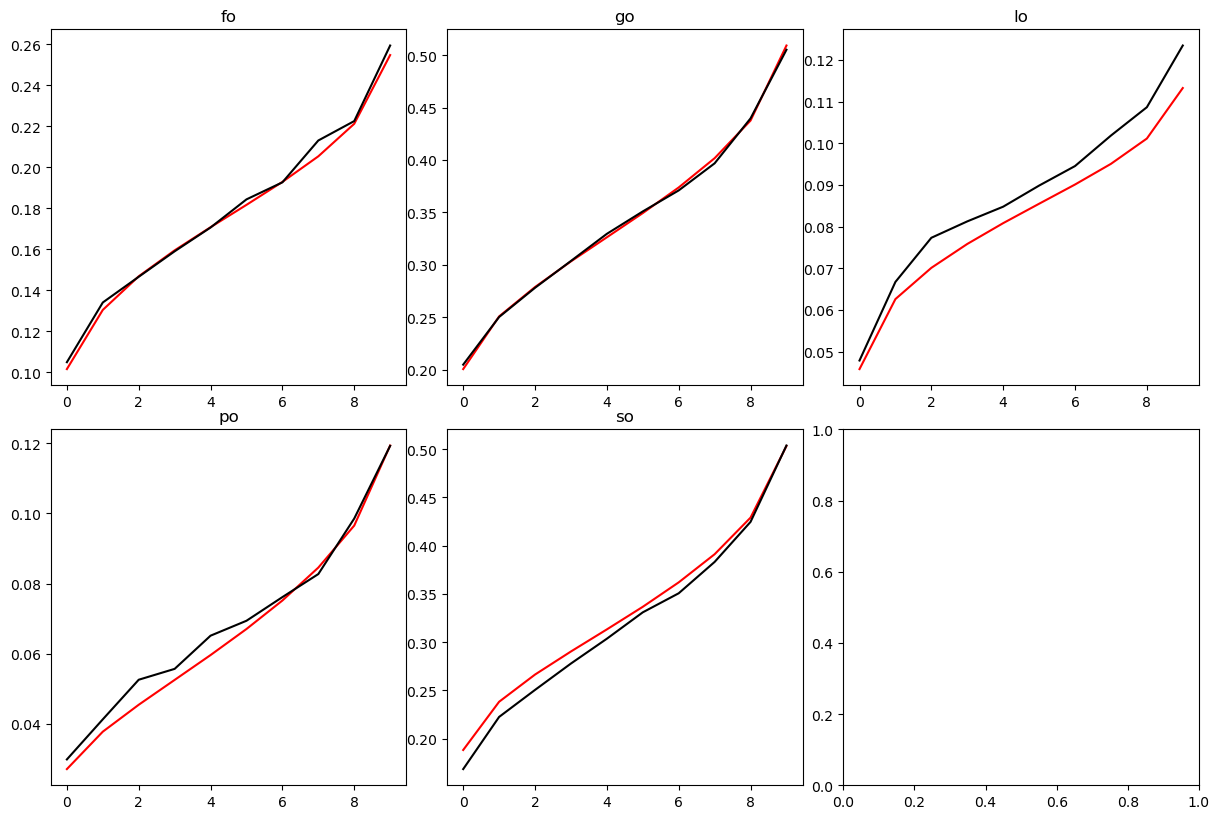

In [40]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    df_name = var + "_df"
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [185]:
len(safe_dataset_train)

326727

### Safe

In [233]:
%%time
# Neural network layers
layers = (40,40,40)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 20
# Alpha
alpha = 0.0001
# Random state
random_state = 1

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=(100,), activation=activation, verbose=True, alpha=alpha, early_stopping=True, validation_fraction=0.1, random_state=random_state+1, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(200,), activation=activation, verbose=True, alpha=alpha, early_stopping=True, validation_fraction=0.1, random_state=random_state+2, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, validation_fraction=0.1, random_state=random_state+3, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, validation_fraction=0.1, random_state=random_state+4, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, validation_fraction=0.1, random_state=random_state+7, max_iter=iters),
    ]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_dataset_train[pa_inputs], safe_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

model_safe_relu_404040_30_20240128.sav
CPU times: total: 281 ms
Wall time: 2min 27s


In [234]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_dataset_test[pa_inputs])
for i, col in enumerate(safe_outputs_pred):
    safe_dataset_test[f'{col}'] = proba[:, i]

In [235]:
# Create deciles
for var in safe_outputs:
    safe_dataset_test[f'{var}_act'] = (safe_dataset_test['eventsModel'] == var).astype('int')
    safe_dataset_test['decile'] = pd.qcut(safe_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = safe_dataset_test.groupby('decile').mean().reset_index()

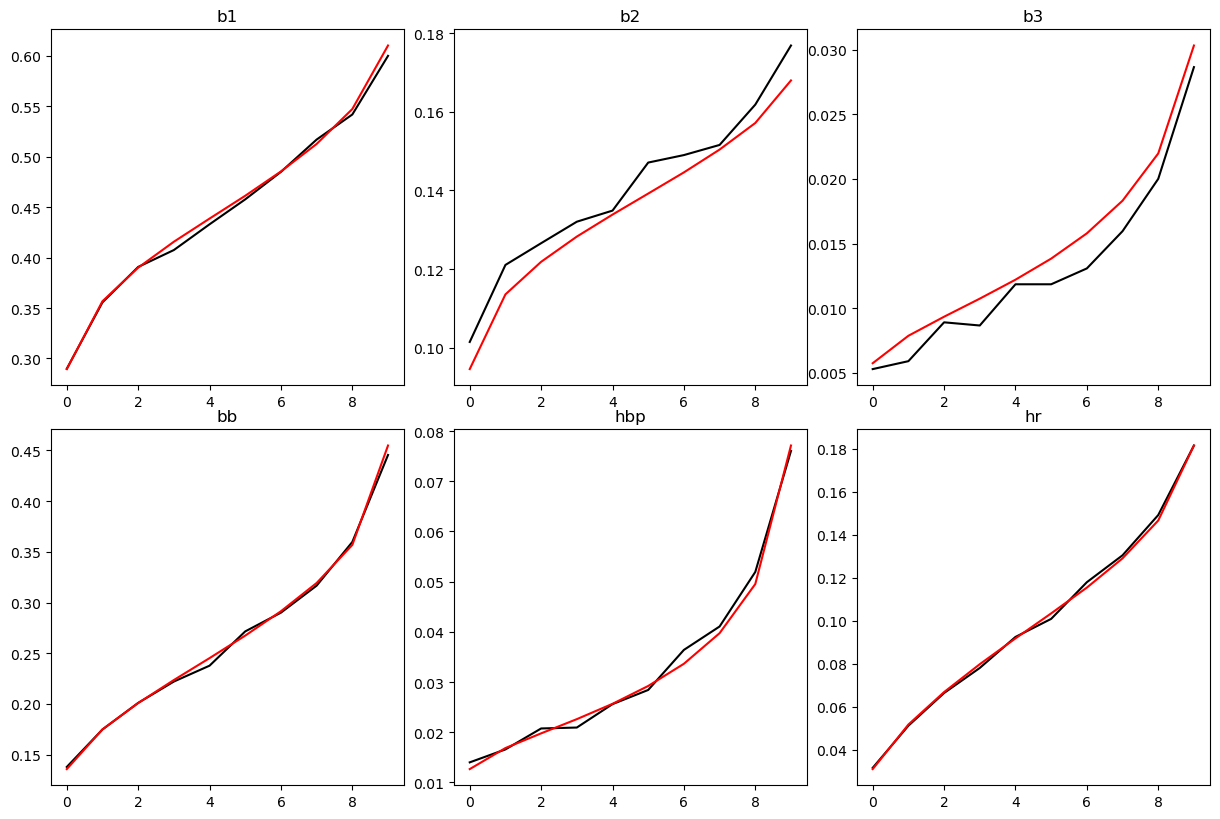

In [236]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    df_name = var + "_df"
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[df_name]['decile'], globals()[df_name][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [237]:
safe_dataset_test.groupby('decile')[['hr_pred', 'hr_act']].mean()

,hr_pred,hr_act
decile,,
0,0.031021,0.031611
1,0.051750,0.051194
2,0.066859,0.066417
3,0.079828,0.078080
4,0.091834,0.092505
5,0.103468,0.100915
6,0.115469,0.117979
7,0.129077,0.130502
8,0.146680,0.149223


In [169]:
adfa

NameError: name 'adfa' is not defined

In [ ]:
safe_dataset_test.groupby('decile')[['hr_pred', 'hr_act']].mean()

In [ ]:
safe_dataset_test.query('year == "2022" | year == "2023"')[['b1_pred', 'b1_act', 'b2_pred', 'b2_act', 'b3_pred', 'b3_act', 'hr_pred', 'hr_act', 'bb_pred', 'bb_act', 'hbp_pred', 'hbp_act']].mean()

In [ ]:
outs_dataset_test.query('year == "2022" | year == "2023"')[['fo_pred', 'fo_act', 'go_pred', 'go_act', 'lo_pred', 'lo_act', 'po_pred', 'po_act', 'so_pred', 'so_act']].mean()

In [ ]:
import pandas as pd

# Read the log file into a DataFrame
df = pd.read_csv('model_logs.log', header=None, delimiter=',', skipinitialspace=True)

# Rename the columns
df.columns = [f'col{i+1}' for i in range(len(df.columns))]

# Display the DataFrame
# print(df.head())
df['col2'] = df['col2'].str.split("\[\[", expand=True)[1]
df['col2'] = df['col2'].astype('float')
df['col157'] = df['col157'].str.replace("\]", "").astype('float')
df['col168'] = 1

col_names = ['time'] + pa_inputs + ['hbp', 'bb', 'b1', 'b2', 'b3', 'hr', 'so', 'lo', 'po', 'go', 'fo']
# Rename the columns
df.columns = col_names

df['fo'] = df['fo'] - df['go']
df['go'] = df['go'] - df['po']
df['po'] = df['po'] - df['lo']
df['lo'] = df['lo'] - df['so']
df['so'] = df['so'] - df['hr']
df['hr'] = df['hr'] - df['b3']
df['b3'] = df['b3'] - df['b2']
df['b2'] = df['b2'] - df['b1']
df['b1'] = df['b1'] - df['bb']
df['bb'] = df['bb'] - df['hbp']

df['safe'] = df[['hbp', 'bb', 'b1', 'b2', 'b3', 'hr']].sum(axis=1)
df['out'] = df[['so', 'lo', 'po', 'go', 'fo']].sum(axis=1)

for stat in ['hbp', 'bb', 'b1', 'b2', 'b3', 'hr']:
    df[f'{stat}_pred'] = df[stat] / df['safe']
df.describe()

In [ ]:
safe_dataset_test.describe()

In [ ]:
# Why are doubles bad? We're not counting DPs, right?